# Consumer Behavior Analytics - Data Modelling  of `customers_exposed`

**Libraries and imports**

In [1]:
# Basic DS libraries
import pandas as pd
import numpy as np

# DataViz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics Libraries
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Data Utils
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
                                                                     recall_score, \
                                                                     precision_score, \
                                                                     accuracy_score, \
                                                                     roc_auc_score, \
                                                                     auc, \
                                                                     plot_confusion_matrix, \
                                                                     plot_roc_curve
                                                                         
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,\
                             AdaBoostClassifier,\
                             GradientBoostingClassifier,\
                             VotingClassifier
from xgboost import XGBClassifier

import pickle
import joblib

# Notebook setup
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Loading customers exposed
customers_exposed = pd.read_csv('../data/customers_exposed_ohe.csv')

In [3]:
customers_exposed.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age,Dt_Customer_InDays,Lives_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,3,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,1,58138.0,1617,0.027813,25,64.68,57,37,1,0,0,1,0,0
1,5,30351.0,1,0,19,14,0,24,3,3,2,1,3,0,2,9,0,1,3,10117.0,46,0.004547,6,7.67,40,312,0,0,0,0,1,0
2,5,5648.0,1,1,68,28,0,6,1,1,13,1,1,0,0,20,0,0,4,1412.0,49,0.034703,2,24.50,64,592,0,0,0,0,1,0
3,5,82800.0,0,0,23,1006,22,115,59,68,45,1,7,6,12,3,0,1,1,82800.0,1315,0.015882,26,50.58,68,118,1,0,0,1,0,0
4,4,76995.0,0,1,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,3,25665.0,1782,0.069433,26,68.54,65,242,0,0,1,0,0,0


In [4]:
# Checking class balance (or imballance)
customers_exposed['Response'].value_counts(normalize = True)

1    0.5486
0    0.4514
Name: Response, dtype: float64

## Data Preparation

We are going to start preparing the data for modelling regarding both datasets: `customers_whole` and `customers_exposed`, but only until One Hot Encoding.

After that, we will save both one hot encoded dataframes into new csv files and split both analysis in different notebooks. The analysis in this notebook will be for `customers_whole` dataset.

In [5]:
# # Defining Sample first_date
# first_date = customers_whole['Dt_Customer'].min()

# # Transforming datetime feature to numeric feature
# for df in [customers_exposed, customers_whole]:
#     df['Dt_Customer_InDays'] = df['Dt_Customer'] - first_date
    
#     df['Dt_Customer_InDays'] = (df['Dt_Customer_InDays'] / np.timedelta64(1, 'D')).astype(int) + 1
    
#     # Dropping unuseful columns for modelling
#     df.drop(['ID', 'Dt_Customer'], axis = 1, inplace = True)

In [6]:
# # One Hot Encoding categorical features with pd.get_dummies
# customers_exposed_ohe = pd.get_dummies(customers_exposed)
# customers_whole_ohe = pd.get_dummies(customers_whole)

In [7]:
# # Saving One Hot Enconded files into a new csv file
# customers_whole_ohe.to_csv('../data/customers_whole_ohe.csv', header = True, index = False)
# # pd.read_csv('../data/customers_whole_ohe.csv')

# customers_exposed_ohe.to_csv('../data/customers_exposed_ohe.csv', header = True, index = False)
# # pd.read_csv('../data/customers_exposed_ohe.csv')

Both files have been saved! We will not need to load the `customers_whole_ohe.csv` into this notebook, but it is aways good to keep a standartd log of actions.

**We will move forward with modelling for the `customers_whole` dataset hereafter.**

Let's start:

### Splitting Data into _Train_, _Validation_ and _Test_ sets

We will split the data according to the following schedule:

- Create a `df_train` and a `df_test`.
- From the previous `df_train` we will once again split it into two: `df_train` and `df_val`.

We also know that _specially_ in this dataset (`_whole`) we have unballanced data. So we will perform a oversampling technique called SMOTE. According to the paper published in _The Journal of Artificial Intelligence Research_ in 2002:

> [With SMOTE] The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the $k$ minority class nearest neighbors. Depending upon the amount of over-sampling required, neighbors from the k nearest neighbors are randomly chosen.[$^{SMOTE: \: Synthetic\:Minority\:Over-sampling\:Technique}$](https://arxiv.org/pdf/1106.1813.pdf)

- Finally, we will separate all dfs into `X`'s and `y`, naming respectively accordint to the df they belong to.

Let's start:

In [8]:
# Splitting df_train and df_test for training and testing
df_train, df_test = train_test_split(customers_exposed, test_size = .2, random_state = 7)

In [9]:
# Savint test set to a new csv file
df_test.to_csv('../data/tests_sets/df_test_pure-customers_exposed.csv', header = True, index = False)

In [10]:
# Splitting df_train into df_train and df_val
df_train, df_val = train_test_split(df_train, test_size = .2, random_state = 7)

In [11]:
# Checking target variable balance (or imballance)
df_train['Response'].value_counts()

1    212
0    176
Name: Response, dtype: int64

In [12]:
# Balancing target variable with SMOTE technique

# Instantiating SMOTER over_sampler
smote = SMOTE(random_state = 7)

# Fitting and resampling data with SMOTE
X_train, y_train = smote.fit_resample(df_train.drop('Response', axis = 1), df_train['Response'])

# Checking target class balance
y_train.value_counts()

0    212
1    212
Name: Response, dtype: int64

In [13]:
X_val = df_val.drop('Response', axis = 1)
y_val = df_val['Response']

X_test = df_test.drop('Response', axis = 1)
y_test = df_test['Response']

Let's check if the generated `X`'s and `y`'s are correctly built:

In [14]:
print('X_train, y_train   shapes: ', X_train.shape, y_train.shape)
print('X_val  , y_val     shapes: ', X_val.shape, y_val.shape)
print('X_test , y_test    shapes: ', X_test.shape, y_test.shape)

X_train, y_train   shapes:  (424, 31) (424,)
X_val  , y_val     shapes:  (97, 31) (97,)
X_test , y_test    shapes:  (122, 31) (122,)


**All shapes match**. We are good to go on.

### Analyzing multicolinearity

In the previous notebooks, we have created new variables from pre-existing variables. Therefore we made room for possible multicolinearity.

Some techniques for analyzing multicolinearity are:

- Checking correlation values between variables;
- Checking the Variance Inflation Factor (VIF) and dropping variables with factor $> 10$;
- Performing Principal Component Analysis, to the cost of lesser interpretability;
- Perform regularization such as (Lasso or Ridge) for linear models, such as Logistic Regression;

For the sake of simplicity, let's go foward with `VIF` and drop variables with factor $ >10$:

In [15]:
# Recovering X_train columns
# X_train.columns.tolist()

In [16]:
# Separating numeric features in a list, except booleans
numeric_features = [
    'Education',
    'Income',
    'Kidhome',
    'Teenhome',
    'Recency',
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    'Complain',
    'Family_Size',
    'Income_PerCap',
    'Total_Spent',
    'Prop_Spending_Income_pc',
    'Total_Puchases',
    'Avg_Ticket',
    'Age',
    'Dt_Customer_InDays',
    'Lives_Alone',
]

In [17]:
# Creating a list of varibles for VIF analysis

################################################################################################
#   This cell has been iterated "mannually" after checking vif values in the dataframe below   #
################################################################################################

numeric_features_vif_ok = [
#     'Education',
#     'Income',
#     'Kidhome',
#     'Teenhome',
    'Recency',
#     'MntWines',
#     'MntFruits',
#     'MntMeatProducts',
#     'MntFishProducts',
#     'MntSweetProducts',
#     'MntGoldProds',
#     'NumDealsPurchases',
#     'NumWebPurchases',
#     'NumCatalogPurchases',
#     'NumStorePurchases',
#     'NumWebVisitsMonth',
    'Complain',
    'Family_Size',
    'Income_PerCap',
#     'Total_Spent',
#     'Prop_Spending_Income_pc',
#     'Total_Puchases',
    'Avg_Ticket',
#     'Age',
    'Dt_Customer_InDays',
    'Lives_Alone',
]

In [18]:
# Creating a dataframe for storing vif and its respective variable
vif_df = pd.DataFrame()

# Calculating vif values and saving it into vif_index columns
vif_df["vif_index"] = [vif(X_train[numeric_features_vif_ok].values, i) \
                               for i in range(X_train[numeric_features_vif_ok].shape[1])]

# Saving variable name into feature column
vif_df["feature"] = X_train[numeric_features_vif_ok].columns

# Checking results
vif_df

,vif_index,feature
0,3.552680,Recency
1,1.019633,Complain
2,4.042938,Family_Size
3,4.177922,Income_PerCap
4,1.516791,Avg_Ticket
5,3.590459,Dt_Customer_InDays
6,2.140468,Lives_Alone


In [19]:
# Listing variables to be dropped due to high VIF
to_drop_from_vif = [feature for feature in numeric_features if feature not in numeric_features_vif_ok]

In [20]:
# to_drop_from_vif

All `VIF` factor are now $\le 10$, we can start dealing with the different orders of magnitude in our numeric features scaling them propperly.

### Scaling

In order to have the numeric data in the same order of magnite, we will:

- Use RobustScaler for variables with outliers;
- Use StandardScaler for variables with no outliers;
- Drop values outstands even after scaling.


Let's start by listing features with outliers:

**Getting features with ouliers**

In [21]:
# Listing features names if feature has outlier
to_robust_scale = []
for feature in numeric_features:
    
    Q1 = np.percentile(X_train[feature].sort_values(), 25, interpolation = 'midpoint')  
    Q3 = np.percentile(X_train[feature].sort_values(), 75, interpolation = 'midpoint')  

    IQR = Q3 - Q1  
    
    low_lim = Q1 - 1.5 * IQR 
    up_lim = Q3 + 1.5 * IQR 

    if (X_train[feature] > up_lim).any() or (X_train[feature] < low_lim).any(): 
         to_robust_scale.append(feature)

# View list of variables to scale with RobustScaler
# to_robust_scale 

And then, from the previous list, we can list the variables that will be standardized:

**Listing features _without_ outliers**

In [22]:
# Listing all other numeric features
to_standardize = [feature for feature in numeric_features if feature not in to_robust_scale]

# View list of variables to scale with StandScaler
# to_standardize

**Applying RobustScaler to variables listed in `to_robust_scale` list**

In [23]:
robust_scaler = RobustScaler()
robust_scaler.fit(X_train[to_robust_scale])

X_train_scaled = X_train.copy()
X_train_scaled[to_robust_scale] = robust_scaler.transform(X_train[to_robust_scale])

**Applying StandardScaler to variables listed in `to_standardize` list**

In [24]:
stand_scaler = StandardScaler()

stand_scaler.fit(X_train[to_standardize])
X_train_scaled[to_standardize] = stand_scaler.transform(X_train[to_standardize])

Let's check the `X_train` dataset to see if everything went well:

In [25]:
# Checking statistics from scaled DFs
round(X_train_scaled.describe(), 2)

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age,Dt_Customer_InDays,Lives_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
count,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.0,424.00,424.00,424.00,424.00
mean,0.54,0.00,0.00,0.00,0.00,0.00,0.38,0.34,0.41,0.43,0.38,0.59,0.00,-0.00,0.00,-0.21,0.00,0.35,0.23,-0.00,0.10,0.00,0.23,-0.00,-0.00,-0.00,0.1,0.33,0.23,0.24,0.04
std,0.97,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.91,0.98,0.98,0.95,1.00,1.00,1.00,0.66,0.05,0.94,0.86,1.00,0.69,1.00,1.78,1.00,1.00,1.00,0.3,0.47,0.42,0.43,0.20
min,-2.00,-2.58,-0.66,-0.74,-1.57,-1.27,-0.39,-0.30,-0.29,-0.32,-0.61,-0.50,-1.92,-1.36,-1.95,-1.50,0.00,-1.00,-0.94,-1.37,-0.93,-2.40,-0.78,-2.33,-1.59,-0.78,0.0,0.00,0.00,0.00,0.00
25%,0.00,-0.85,-0.66,-0.74,-0.84,-0.93,-0.32,-0.22,-0.25,-0.28,-0.28,0.00,-0.75,-1.02,-0.74,-0.75,0.00,0.00,-0.46,-0.99,-0.43,-0.67,-0.46,-0.69,-0.88,-0.78,0.0,0.00,0.00,0.00,0.00
50%,0.00,0.12,-0.66,-0.74,-0.10,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,-0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.20,-0.00,-0.08,-0.10,-0.78,0.0,0.00,0.00,0.00,0.00
75%,1.00,0.80,1.40,1.09,0.82,0.78,0.68,0.78,0.75,0.72,0.72,1.00,0.79,0.71,0.78,0.25,0.00,1.00,0.54,0.82,0.57,0.64,0.54,0.84,0.84,1.28,0.0,1.00,0.00,0.00,0.00
max,2.00,2.09,3.45,2.93,1.86,2.39,4.00,3.63,3.41,3.87,3.61,5.00,2.34,2.43,1.99,3.50,1.00,3.00,2.76,2.29,2.83,2.37,32.99,2.26,1.79,1.28,1.0,1.00,1.00,1.00,1.00


The dataset almost alright alright. Some values are still outstanding and they might disturb distance based models. 

Let's drop these values:

In [26]:
idx_avg_ticket_to_drop = (X_train_scaled[X_train_scaled['Avg_Ticket'] > \
                                                 np.percentile(X_train_scaled['Avg_Ticket'], 99)].\
                          sort_values('Avg_Ticket', ascending = False).head(2)).index
idx_avg_ticket_to_drop

for df in [X_train, X_train_scaled, y_train]:
    df.drop(idx_avg_ticket_to_drop, inplace = True)

round(X_train_scaled.describe(), 2)

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age,Dt_Customer_InDays,Lives_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
count,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.00,422.0,422.00,422.00,422.00,422.00
mean,0.55,-0.00,0.00,0.00,-0.00,0.00,0.38,0.32,0.41,0.42,0.38,0.60,0.01,0.00,0.00,-0.21,0.00,0.35,0.23,-0.01,0.10,0.01,0.13,0.00,0.00,0.00,0.1,0.33,0.23,0.24,0.04
std,0.97,1.00,1.00,1.00,1.00,1.00,0.99,0.66,0.90,0.97,0.98,0.95,1.00,1.00,1.00,0.66,0.05,0.95,0.86,1.00,0.69,1.00,0.65,1.00,1.00,1.00,0.3,0.47,0.42,0.43,0.20
min,-2.00,-2.58,-0.66,-0.74,-1.57,-1.27,-0.39,-0.30,-0.29,-0.32,-0.61,-0.50,-1.53,-1.36,-1.95,-1.25,0.00,-1.00,-0.94,-1.37,-0.93,-2.26,-0.78,-2.33,-1.59,-0.78,0.0,0.00,0.00,0.00,0.00
25%,0.00,-0.85,-0.66,-0.74,-0.84,-0.93,-0.32,-0.22,-0.25,-0.28,-0.28,0.00,-0.75,-1.02,-0.74,-0.75,0.00,0.00,-0.46,-1.00,-0.43,-0.67,-0.46,-0.66,-0.87,-0.78,0.0,0.00,0.00,0.00,0.00
50%,0.00,0.11,-0.66,-0.74,-0.12,-0.08,0.00,-0.00,0.00,0.00,0.00,0.00,0.02,0.02,-0.13,0.00,0.00,0.00,-0.02,-0.00,-0.00,0.20,-0.01,-0.08,-0.10,-0.78,0.0,0.00,0.00,0.00,0.00
75%,1.00,0.81,1.40,1.09,0.82,0.78,0.67,0.78,0.75,0.71,0.72,1.00,0.79,0.71,0.78,0.25,0.00,1.00,0.54,0.81,0.56,0.64,0.54,0.84,0.84,1.28,0.0,1.00,0.00,0.00,0.00
max,2.00,2.09,3.45,2.93,1.86,2.39,4.00,2.10,3.41,3.87,3.61,5.00,2.34,2.43,1.99,3.50,1.00,3.00,2.76,2.29,2.83,2.37,1.98,2.26,1.79,1.28,1.0,1.00,1.00,1.00,1.00


Aiming to avoid **data leakage**, we've performed the `.fit` method using only the `X_train` dataset. We need now to `.transform` the values from `X_val` and `X_test` datasets so we can use them later to make predictions and evaluate our model.

In [27]:
# Transforming x_val and x_test with scalers from X_train
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_val_scaled[to_robust_scale] = robust_scaler.transform(X_val[to_robust_scale])
X_test_scaled[to_robust_scale] = robust_scaler.transform(X_test[to_robust_scale])

X_val_scaled[to_standardize] = stand_scaler.transform(X_val[to_standardize])
X_test_scaled[to_standardize] = stand_scaler.transform(X_test[to_standardize])

In [28]:
# Checking transformed datasets
# X_val.head() # Uncomment to view dataframes
# X_test.head()

In [29]:
# Saving all new dataframes and target variables to a new csv for posterior recover

X_train.to_csv('../data/tests_sets/X_train-customers_exposed.csv', header = True, index = False)
X_train_scaled.to_csv('../data/tests_sets/X_train_scaled-customers_exposed.csv', header = True, index = False)
y_train.to_csv('../data/tests_sets/y_train-customers_exposed.csv', header = True, index = False)

X_val.to_csv('../data/tests_sets/X_val-customers_exposed.csv', header = True, index = False)
X_val_scaled.to_csv('../data/tests_sets/X_val_scaled-customers_exposed.csv', header = True, index = False)
y_val.to_csv('../data/tests_sets/y_val-customers_exposed.csv', header = True, index = False)

X_test.to_csv('../data/tests_sets/X_test-customers_exposed.csv', header = True, index = False)
X_test_scaled.to_csv('../data/tests_sets/X_test_scaled-customers_exposed.csv', header = True, index = False)
y_test.to_csv('../data/tests_sets/y_test-customers_exposed.csv', header = True, index = False)

## Metrics

Befome moving foward to modelling. Let's identify what metrics is more likely to give us the best results.

And for choogins a good metric, it is always important to callback our business problem:

>**We want to correctly classify potential buyer for the company's new device, but there's a cost associated with advertising for customers who will never buy it in first place.**

Having that in mind, let's list some of the most important metrics for classification problems:

- **Accuracy**: the ratio of correct predictions. The model is not worried about how wrong it predicted. This might be a problem in a binary classification model that predicts only one class for unballanced data.
- **Precision**: measures the ratio of correct predictions of a class. Can generate too many false alarms.
- **Recall**: measures the ability to detect occurences of a class of interest. We could choose this metrics if we weren't concerned with the cost associated with predicting one class wrongly.
- **F1-score**: the harmonic mean of precision and recall. Measures a model's ability to identify occurences of a class while limiting false alarms. This is a go-to metric!


**F1-Score is the metric we are looking for to comply with our task and maximize profits from device sales.**

Let's keep this metric in mind when analyzing the models, starting with a baseline model.

## Baseline Model

Let's start with a baseline model.

A baseline model is a good pratice to determine if all sweat put into modelling with different algorithms and hyperparameter tuning is worth the effort.

We can use a simple **Linear Regression**, not tunned, model as our baseline.

### Simple LinearRegression

In [30]:
# Instantiating the model
log_model = LogisticRegression()

# Fitting the model
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [31]:
# Checking classification report
print(classification_report(y_val, log_model.predict(X_val_scaled)))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        39
           1       0.81      0.79      0.80        58

    accuracy                           0.76        97
   macro avg       0.75      0.76      0.75        97
weighted avg       0.76      0.76      0.76        97



**We have pretty good metrics for our baseline model!** A lot better than previous results, when analyzing the whole dataset.

Better be safe and cross validate our results. 

For that, we will be using the RandomSearchCV with empty `param_distribution` params. This will allow us to use the model object to `.fit` and `.predict` and therefore we will be able to produce a second `classification_report` that wouldn't be possible with Scikit-Learn `cross_validade`.

In [32]:
# Instantiating RandomizedSearchCV with empty param_distributions
log_model_rsearch = RandomizedSearchCV(log_model, 
                                       param_distributions = {}, 
                                       cv = 10, 
                                       n_iter = 1, # Not useful when param_distributions is an empty dict
                                       scoring = 'f1', 
                                       random_state = 7)

In [33]:
# Fitting baseline model
log_model_rsearch.fit(X_train_scaled, y_train)

# Getting baseline model prediction
y_val_pred = log_model_rsearch.predict(X_val_scaled)
# y_val_pred

In [34]:
# Evaluating metrics with Skelearn Classification Report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        39
           1       0.81      0.79      0.80        58

    accuracy                           0.76        97
   macro avg       0.75      0.76      0.75        97
weighted avg       0.76      0.76      0.76        97



Results remain robusts even after cross validation.

Too good to be true? Let's analyze it even further with a `AUC` curve and a `confusion_matrix`:

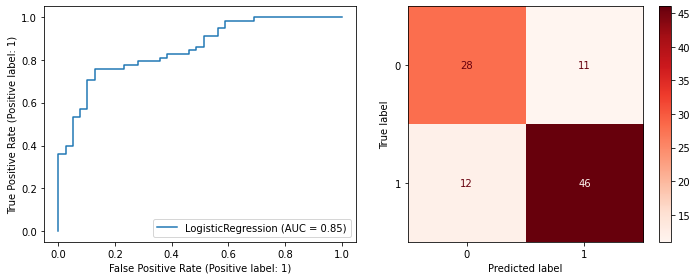

In [35]:
# Plotting AUC and Confusion Matrix side by side
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

# AUC Plot
plot_roc_curve(log_model, X_val_scaled, y_val, ax = ax[0])

# Confusion Matrix
plot_confusion_matrix(log_model, X_val_scaled, y_val, cmap=plt.cm.Reds, ax = ax[1])
plt.tight_layout()

### Keeping metrics logs in MLFlow

Data science is an interative process. In order to keep track of performance metrics, let's instantiate a MLFlow Client.

MLFlow will free us to modify and test unlimitedly while not fearing to lose our best model.

In [37]:
from mlflow.tracking import MlflowClient

# Naming Experiment
EXPERIMENT_NAME = '[v4.8] [customers_exposed] [Consumer Behavior Analytics] [Renan Moises]'

# Instantiating MLFlow Client
client = MlflowClient()

# Saving experiment with experiment_id variable
experiment_id = client.create_experiment(EXPERIMENT_NAME)

In [38]:
# Defining metrics to keep track of. We will discuss them later.
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
metrics = [accuracy_score, precision_score, recall_score, f1_score]

In [39]:
# Creating a run for MlFlow Client
run = client.create_run(experiment_id)

# Logging params: Model Name
client.log_param(run.info.run_id, 'model', 'LogistRegression-Baseline')

# Iteration over metrics and logging them
for metric in zip(metrics_names, metrics):
    client.log_metric(run.info.run_id, metric[0], metric[1](y_val, y_val_pred))

In [40]:
# Saving baseline model into a pickle file
with open(f"../models/v2_pkl_cexposed_Logistic_Regression-Baseline.pkl", "wb") as file:
    pickle.dump(log_model_rsearch, file)

## Modelling

Some of the most known classification algorithms are:

- **LogisticRegression**;
- **KNNClassifier**;
- **SVC (Support Vector Classifier)**;
- **RFClassifier**;
- **AdaBoostClassifier**;
- **GradientBoostClassifier**;
- **XGBoostClassifier**.


Apart from these ones (and many others) there's still the possibility of _stacking_ two or more modules as well as combining them into a _voting_ classifier, but we will be leavig these ones for the next steps of this analysis, after approval of the CMO.

For now, we will go with the "basic" ones listed above and for that, we will go semi-automatic: first creating a dictionary with model names and models, so that we can iterate over it, and then, well... effectively iterate over it with a `for` loop.

<small>_NOTE_: Ideally, this would have been built within a `pipeline` and called with `python classes`. That implementation, altough very important in terms of machine learning engineering, will be left for the future though.</small>

In [41]:
# Dictionary of model_keys and model_values (the algorithms, instantiated)
models = {
    'LogisticRegression-Tunned': LogisticRegression(),
    'KNNClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGboostClassifier': XGBClassifier()
}

In [42]:
# Big long mannually interative for loop (Not ideal, but code works just fine!)
for model_key, model_value in models.items():
#     X_train_modelling = X_train.copy().drop(to_drop_from_vif, axis = 1)
#     X_val_modelling = X_val.copy().drop(to_drop_from_vif, axis = 1)
    
    X_train_modelling = X_train.copy()
    X_val_modelling = X_val.copy()

    
    if model_key == 'LogisticRegression-Tunned':
        # Dropping Multicolinear Features for Logistic Regression
        X_train_modelling = X_train_scaled.drop(to_drop_from_vif, axis = 1)
        X_val_modelling = X_val_scaled.drop(to_drop_from_vif, axis = 1)
        
        param_grid = {
            'penalty': ['l2', 'l1', 'elasticnet'],
            'tol': stats.loguniform(0.1, 1),
            'C': stats.loguniform(3, 10)
        }
    
    elif model_key == 'KNNClassifier':
        # Dropping Multicolinear Features for KNNClassifier
        X_train_modelling = X_train_scaled.drop(to_drop_from_vif, axis = 1)
        X_val_modelling = X_val_scaled.drop(to_drop_from_vif, axis = 1)
        
        param_grid = {'n_neighbors':[3, 4, 5, 6, 7]}
    
    elif model_key == 'SVC':
        # Dropping Multicolinear Features for SVC
        X_train_modelling = X_train_scaled.drop(to_drop_from_vif, axis = 1)
        X_val_modelling = X_val_scaled.drop(to_drop_from_vif, axis = 1)
        
        param_grid = {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': stats.loguniform(3, 20)
        }
    
    elif model_key == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': np.arange(0, 10),
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
        }
    
    elif model_key == 'AdaBoostClassifier':
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'learning_rate': stats.lognorm(.001, 1)
        }
    
    elif model_key == 'GradientBoostingClassifier':
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'learning_rate': stats.lognorm(.001, 1),
            'min_samples_split': np.arange(0, 10),
            'min_samples_leaf': [1, 2, 4],
            'max_depth': np.arange(0, 10)
        }
    
    else:
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'learning_rate': stats.loguniform(.001, 1),            
            'max_depth': np.arange(0, 10),
            'gamma': stats.loguniform(.001, 1),
        }   
    
    
    # Running RandomizedSearchCV
    print(model_key, '#'.replace('#', '#'*(61 - len(model_key))))
    model_rsearch = RandomizedSearchCV(model_value, 
                                       param_distributions = param_grid, 
                                       n_iter = 50, 
                                       scoring = 'f1', # Used to update weights
                                       cv = 10, 
                                       n_jobs = -1, 
                                       verbose = 1,
                                       random_state = 7)
    
    # Fitting the model to the train data
    model_rsearch.fit(X_train_modelling, y_train)
    
    # Saving model as a joblib file
#     joblib.dump(model_rsearch, f'../models/cexposed_{model_key}.pkl')
    with open(f"../models/v2_pkl_cexposed_{model_key}.pkl", "wb") as file:
        pickle.dump(model_rsearch, file)

    
    # Predictions using X_val
    y_val_pred = model_rsearch.predict(X_val_modelling)
    
    # Setting up metrics
    metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    
    # MLFlow Logs
    run = client.create_run(experiment_id)
    for metric_name, metric in zip(metrics_names, metrics):
        client.log_metric(run.info.run_id, metric_name, metric(y_val, y_val_pred))
    client.log_param(run.info.run_id, "model", model_key)
    client.log_param(run.info.run_id, "params", model_value.get_params())
    client.log_param(run.info.run_id, "features", X_train_modelling.columns.tolist())

    
    print(classification_report(y_val, y_val_pred), '\n')

LogisticRegression-Tunned ####################################
Fitting 10 folds for each of 50 candidates, totalling 500 fits
              precision    recall  f1-score   support

           0       0.63      0.62      0.62        39
           1       0.75      0.76      0.75        58

    accuracy                           0.70        97
   macro avg       0.69      0.69      0.69        97
weighted avg       0.70      0.70      0.70        97
 

KNNClassifier ################################################
Fitting 10 folds for each of 5 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.60      0.54      0.57        39
           1       0.71      0.76      0.73        58

    accuracy                           0.67        97
   macro avg       0.65      0.65      0.65        97
weighted avg       0.67      0.67      0.67        97
 

SVC ##########################################################
Fitting 10 folds for each of 

### Best overall model

Analyzing the previous `classification_report`'s, the best overall model still is our **baseline Logistic Regression model**.

The second best was XGBoost. For the sake of simplicity we will move forward analyzing only the very best, the Logistic Regression.

Gone are the days that we would analyze the whole dataset. We've just confirmed that more important than tunning the models, working upon a dataset with only customers' who been guaranteedly exposed to the marketing campaign is very effective.

Since all models (and datasets) have been dully saved into its respective files, we can continue the **best model and interpretability** analysis in a new notebook.

___________________

In [43]:
############# DRAFTS

In [44]:
# rf_model_fromfor = joblib.load('../models/v2_pkl_cexposed_RandomForestClassifier.pkl')
# params = rf_model_fromfor.best_params_

In [ ]:
# X_train_scaled.rename(columns={'Education_2n Cycle': 'Education_2n_Cycle'}, inplace = True)
# X_val_scaled.rename(columns={'Education_2n Cycle': 'Education_2n_Cycle'}, inplace = True)
# X_test_scaled.rename(columns={'Education_2n Cycle': 'Education_2n_Cycle'}, inplace = True)

In [ ]:
# voting_model = VotingClassifier(estimators = [('log_model', LogisticRegression()),
#                                               ('rfc_model', RandomForestClassifier(**params))],
#                                 voting = 'hard', weights = [1.2, .8])

In [ ]:
# voting_model.fit(X_train_scaled, y_train)

In [ ]:
# voting_model.predict(X_val_scaled)

In [ ]:
# print(classification_report(y_test, voting_model.predict(X_test_scaled)))